<a href="https://colab.research.google.com/github/lnsayer/personal_repo/blob/main/drug%20discovery%20with%20BACE%20dataset/graph_classification_bace_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installed rdkit, torch_geometric, deepchem, networkx, torchmetrics into google drive with pip. With this resource https://netraneupane.medium.com/how-to-install-libraries-permanently-in-google-colab-fb15a585d8a5
# This method ends up taking around 200s, whilst installing the libraries themselves takes around 100s which is more efficient.

In [2]:
from timeit import default_timer as timer

In [3]:
start_time = timer()
rd_kit_start_time = timer()
!pip install rdkit
rd_kit_end_time = timer()

torch_geometric_start_time = timer()
!pip install torch_geometric
torch_geometric_end_time = timer()

deep_chem_start_time = timer()
!pip install deepchem
deep_chem_end_time = timer()

networkx_start_time = timer()
!pip install networkx
networkx_end_time = timer()

end_time = timer()

print(f"Time for cell to run: {end_time-start_time:.4f}")
print(f"rd_kit time: {rd_kit_end_time-rd_kit_start_time:.4f}")
print(f"torch_geometric time: {torch_geometric_end_time-torch_geometric_start_time:.4f}")
print(f"deep_chem time: {deep_chem_end_time-deep_chem_start_time:.4f}")
print(f"networkx time: {networkx_end_time-networkx_start_time:.4f}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.2 MB/s eta 0:00:00
Time for cell to run: 27.1195
rd_kit time: 8.3386
torch_geometric time: 6.7302
deep_chem time: 6.9335
networkx time: 5.1171


In [4]:
# Import necessary modules
import requests
from pathlib import Path
import os.path as osp

from rdkit import Chem
from rdkit.Chem import Draw

import torch
import torch_geometric
from torch_geometric.data import InMemoryDataset, Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, GraphConv, GATConv, MLP, GINConv, global_max_pool, SAGPooling, TopKPooling, GINEConv
from torch.nn import Linear, ReLU, Dropout, Softmax
import torch.nn as nn
import torch.nn.functional as F

import deepchem as dc
from deepchem.feat.graph_data import GraphData

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from pandas import DataFrame

import networkx as nx

import random

from tqdm.auto import tqdm
from timeit import default_timer as timer

from IPython.display import Javascript
import pickle

import warnings

warnings.filterwarnings("ignore", message="os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.")

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [5]:
import os
google_drive_path = Path("drive/MyDrive")
# Prints all subdirectories (takes ages)
for dirpath, dirnames, filenames in os.walk(google_drive_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

There are 9 directories and 27 files in 'drive/MyDrive'.
There are 3 directories and 103 files in 'drive/MyDrive/Peru 2019 Expedition'.
There are 1 directories and 0 files in 'drive/MyDrive/Peru 2019 Expedition/Alex's Photos'.
There are 0 directories and 418 files in 'drive/MyDrive/Peru 2019 Expedition/Alex's Photos/Peru 2019'.
There are 0 directories and 0 files in 'drive/MyDrive/Peru 2019 Expedition/Emilie'.
There are 0 directories and 0 files in 'drive/MyDrive/Peru 2019 Expedition/Groña'.
There are 0 directories and 2 files in 'drive/MyDrive/Private'.
There are 0 directories and 50 files in 'drive/MyDrive/Old phone photos'.
There are 0 directories and 37 files in 'drive/MyDrive/Go_pro_gorge_du_verdon_2016'.
There are 0 directories and 36 files in 'drive/MyDrive/Colab Notebooks'.
There are 0 directories and 6 files in 'drive/MyDrive/udemy_ml_course_data'.
There are 3 directories and 0 files in 'drive/MyDrive/bace_graph_project'.
There are 2 directories and 0 files in 'drive/MyDrive/

In [ ]:
bace_project_path = google_drive_path / "bace_graph_project"
bace_raw_path = bace_project_path / "data/raw"

In [7]:
# Check if Bace csv file has been downloaded, if not, download it
if bace_raw_path.is_dir():
  print(f"{bace_raw_path} is already a directory")
else:
  print(f"{bace_raw_path} is not a directory, creating one")
  bace_raw_path.mkdir(parents=True, exist_ok=True)

  with open(bace_raw_path / "bace.csv", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/lnsayer/personal_repo/main/drug%20discovery%20with%20BACE%20dataset/data/bace.csv")
    print("Downloading data")
    f.write(request.content)

drive/MyDrive/bace_graph_project/data/raw is already a directory


In [8]:
# If want to download bace csv straight into colab
data_path = Path("data/")
bace_path = data_path / "raw"

if bace_path.is_dir():
  print(f"{bace_path} is already a directory")
else:
  print(f"{bace_path} is not a directory, creating one")
  bace_path.mkdir(parents=True, exist_ok=True)

  with open(bace_path / "bace.csv", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/lnsayer/personal_repo/main/drug%20discovery%20with%20BACE%20dataset/data/bace.csv")
    print("Downloading data")
    f.write(request.content)

data/raw is not a directory, creating one


In [ ]:
bace_raw_path

In [10]:
# Turn CSV file into a dataframe and resave it without unnecessary columns
bace_df = pd.read_csv(bace_raw_path/ "bace.csv")
bace_df = bace_df[["mol", "CID", "Class", "Model", "pIC50"]]
bace_df.to_csv(bace_raw_path/"bace.csv")

bace_df

,mol,CID,Class,Model,pIC50
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970
...,...,...,...,...,...
1508,Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N,BACE_1543,0,Test,3.000000
1509,Clc1cc2nc(n(c2cc1)C(CC(=O)NCc1ncccc1)CC)N,BACE_1544,0,Test,3.000000
1510,Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1,BACE_1545,0,Test,2.953115
1511,O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N,BACE_1546,0,Test,2.733298


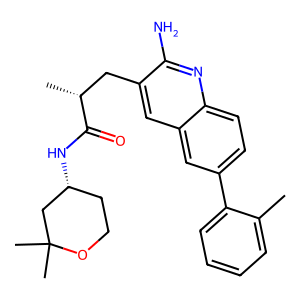

In [11]:
# Visualise one of the molecules from its SMILE input
inhibitor = bace_df["mol"][0]

m = Chem.MolFromSmiles(inhibitor)

img = Draw.MolToImage(m)

display(img)

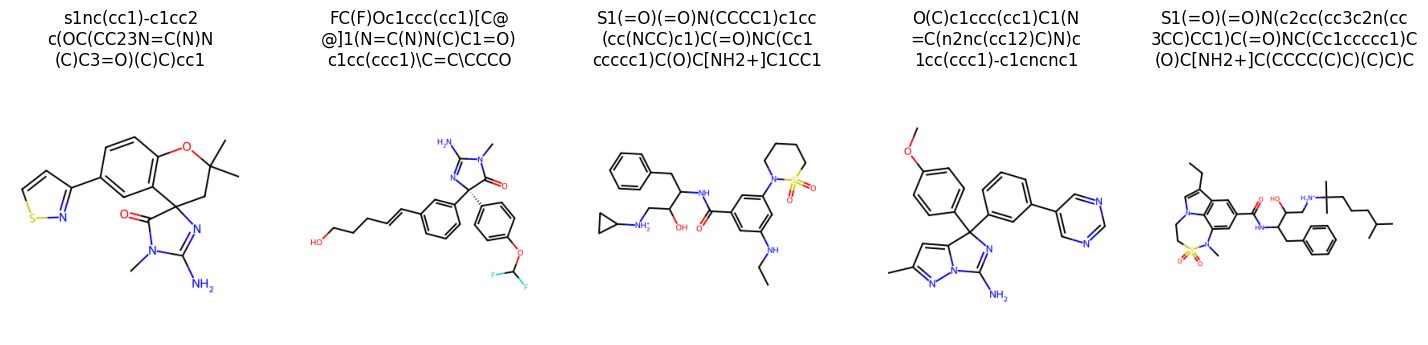

In [12]:
# Display five random molecules with their SMILES molecules

# Create axes and sample SMILES molecules
fig, ax = plt.subplots(ncols=5, nrows=1, figsize = (18,6))
mols = bace_df.sample(n=5, random_state=42)["mol"]

for i in range(len(mols)):

  # Convert each molecule to an image
  mol = mols.iloc[i]
  m = Chem.MolFromSmiles(mol)
  img = Draw.MolToImage(m)

  # Plot each molecule
  ax[i].imshow(img)
  ax[i].axis(False);

  # Divide the SMILE input into three parts
  first_part = mol[:int(len(mol)/3)]
  second_part = mol[int(len(mol)//3):int(2*len(mol)//3)]
  third_part = mol[int(2*len(mol)//3):]

  assert len(mol) == len(first_part)+len(second_part)+len(third_part)

  first_title = first_part + "\n"
  second_title = second_part + "\n"
  third_title = third_part + "\n"

  # Title each plot with its respective SMILE input
  ax[i].set_title(first_title+second_title+third_title)

In [13]:
# Test converting a molecule into a graph using MolGraphConvFeaturizer and to_pyg_graph

# Select first molecule
mol = bace_df["mol"][1]

# Instantiate MolGraphConvFeaturizer class
featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)

# Convert SMILES molecule into a DeepChem graph
out = featurizer.featurize(datapoints=mol)

# Convert into torch geometric graph
pyg_out = GraphData.to_pyg_graph(out[0])
pyg_out.y = torch.tensor([bace_df["Class"][0]])

print(pyg_out)

Data(x=[47, 30], edge_index=[2, 100], edge_attr=[100, 11], y=[1])


In [14]:
# Custom torch geometric Dataset class to store the samples and their corresponding labels

class MoleculeDataset(Dataset):
  def __init__(self, root, csv_file, transform=None, pre_transform=None, pre_filter=None):
    """
    root = Where the dataset should be stored. This folder is split
    into raw_dir (downloaded dataset) and processed_dir(processed data).
    """
    self.csv_file = csv_file
    super().__init__(root, transform, pre_transform, pre_filter)

  @property
  def raw_file_names(self):
    """
    If this file exists in raw_dir, the download is not triggered/
    (the download function is not implemented here)
    """
    return self.csv_file

  @property
  def processed_file_names(self):
    """
    If these files are found in raw_dir, processing is skipped
    """
    self.data = pd.read_csv(self.raw_paths[0]).reset_index()

    return [f'data_{i}.pt' for i in list(self.data.index)]

  def download(self):
    """
    No need to download the csv file as it is already downloaded
    """
    pass

  def process(self):
    """
    I used Deepchem's MolGraphConvFeaturizer to create a graph and then convert that to a torch graph with to_pyg_graph.
    """
    self.data = pd.read_csv(self.raw_paths[0]).reset_index()
    featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)

    for idx, row in self.data.iterrows():
      # Featurize molecule and convert to torch graph
      smiles = row['mol']
      label = row['Class']
      pic50 = row['pIC50']

      out = featurizer.featurize(smiles)
      pyg_out = GraphData.to_pyg_graph(out[0])
      pyg_out.Class = torch.tensor([label])
      pyg_out.smiles = smiles
      pyg_out.pic50 = pic50

      # data = Data(x=pyg_out.x, edge_index=pyg_out.edge_index, edge_attr=pyg_out.edge_attr,
      #            y=torch.tensor([label]), dtype = torch.float)

      torch.save(pyg_out, osp.join(self.processed_dir, f'data_{idx}.pt'))

  def len(self):
    """
    Returns number of samples in the dataset
    """
    return len(self.processed_file_names)

  def get(self, idx):
    """
    Loads a single graph
    """
    data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
    return data

In [15]:
# Instantiate the dataset from the BACE CSV file
start_time = timer()
# original_dataset = MoleculeDataset(root = "drive/MyDrive/bace_graph_project/data/", csv_file = "bace.csv").shuffle()
original_dataset = MoleculeDataset(root = "data/", csv_file = "bace.csv").shuffle()
dataset = original_dataset
end_time = timer()
print(f"Processing dataset took {end_time-start_time:.4f}s")

train_indices = int(0.8*len(dataset))

train_dataset = dataset[:train_indices]
test_dataset = dataset[train_indices:]


print(f"Total dataset samples: {len(dataset)}\nTrain dataset samples: {len(train_dataset)}\nTest dataset samples: {len(test_dataset)}")

Processing...
Done!


Processing dataset took 19.0498s
Total dataset samples: 1513
Train dataset samples: 1210
Test dataset samples: 303


In [ ]:
# Calculate average nodes and edges in the graphs
avg_nodes = 0
avg_edges = 0
"""
for i in tqdm(range(len(original_dataset))):
  avg_nodes+=original_dataset[i].x.shape[0]
  avg_edges+=original_dataset[i].edge_index.shape[1]
avg_nodes = avg_nodes/len(original_dataset)
avg_edges = avg_edges/len(original_dataset)
print(f"avg nodes: {avg_nodes:.4f}, avg_edges: {avg_edges:.4f}")
"""
# Computation takes a long time, results:
print("avg nodes: 34.0892, avg_edges: 73.7184")

In [ ]:
num_workers = 4
# Create a dataloader from the dataset
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=num_workers)

print(f"Number of batches: {len(train_dataloader)}")
print(f"Number of samples: {len(train_dataset)}")

In [ ]:
# Load a single graph

print(f"Number of nodes in graph is: {train_dataset[0].x.shape[0]}")
print(f"Number of features for each node is {train_dataset[0].num_features}")
print(f"Number of edges is {train_dataset[0].edge_index.shape[1]}")
print(f"Data object is {train_dataset[0]}\n")

In [ ]:
# Node features for one the graphs. This class is a featurizer of general graph convolution networks for molecules.
# The default node(atom) and edge(bond) representations are based on WeaveNet paper.

# train_dataset[0].x

In [20]:
# See the format for a batch
print(next(iter(train_dataloader)))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


DataBatch(x=[1173, 30], edge_index=[2, 2532], edge_attr=[2532, 11], Class=[32], smiles=[32], pic50=[32], batch=[1173], ptr=[33])


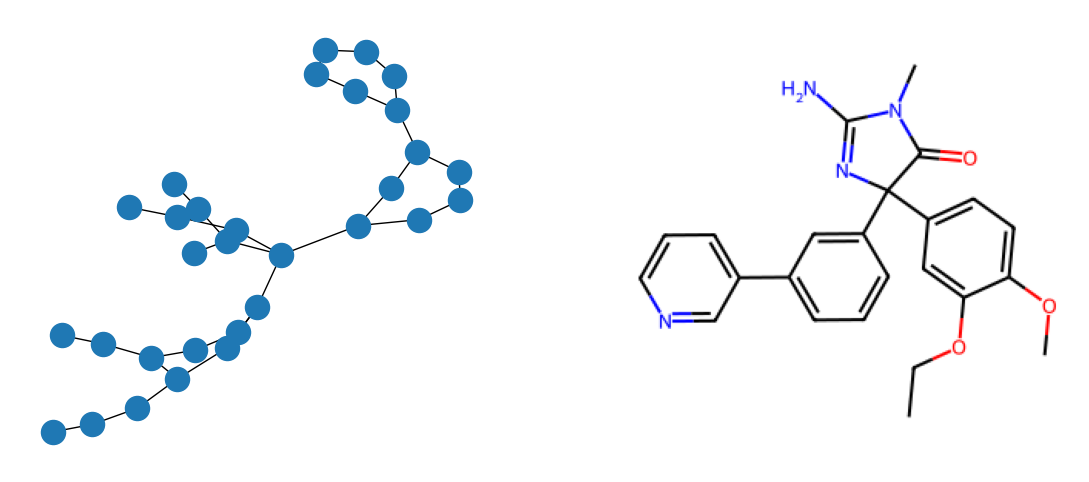

In [21]:
np.random.seed(44)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (14,6))

g = torch_geometric.utils.to_networkx(train_dataset[0], to_undirected=True)
nx.draw(g, ax = ax[0])

mol = dataset[0].smiles
m = Chem.MolFromSmiles(mol)
img = Draw.MolToImage(m)

ax[1].imshow(img)
ax[1].axis(False);

In [22]:
# Print 5 batches
i = 0
for batch in train_dataloader:
  while i <5:
    print(i, batch)
    i+=1

0 DataBatch(x=[1055, 30], edge_index=[2, 2294], edge_attr=[2294, 11], Class=[32], smiles=[32], pic50=[32], batch=[1055], ptr=[33])
1 DataBatch(x=[1055, 30], edge_index=[2, 2294], edge_attr=[2294, 11], Class=[32], smiles=[32], pic50=[32], batch=[1055], ptr=[33])
2 DataBatch(x=[1055, 30], edge_index=[2, 2294], edge_attr=[2294, 11], Class=[32], smiles=[32], pic50=[32], batch=[1055], ptr=[33])
3 DataBatch(x=[1055, 30], edge_index=[2, 2294], edge_attr=[2294, 11], Class=[32], smiles=[32], pic50=[32], batch=[1055], ptr=[33])
4 DataBatch(x=[1055, 30], edge_index=[2, 2294], edge_attr=[2294, 11], Class=[32], smiles=[32], pic50=[32], batch=[1055], ptr=[33])


In [23]:
start_time = timer()
for idx, batch in enumerate(train_dataloader):
  pass
end_time = timer()
print(end_time-start_time)

0.9280031050000161


In [ ]:
# Create tensor of the average of the node features for all 1210 training samples

a = torch.tensor(())
for idx, data in enumerate(train_dataloader):
  x = global_mean_pool(data.x, data.batch)
  a = torch.cat((a, x), 0)


In [25]:

print(a.shape)
df = pd.DataFrame(a.numpy())
# display(df)
corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')


torch.Size([1210, 30])


In [26]:
class GCNClassifier(torch.nn.Module):
  """
  Standard GCN graph classifier
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int, pool_method:torch_geometric.nn.pool):
    super().__init__()
    # Convolutional Layers
    self.conv1 = GCNConv(in_channels, hidden_channels)

    self.conv2 = GCNConv(hidden_channels, hidden_channels)

    self.conv3 = GCNConv(hidden_channels, hidden_channels)

    # Linear layer used in classification
    self.lin = Linear(hidden_channels, out_channels)

  def forward(self, data):
    # Obtain node embeddings
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

    x = self.conv1(x, edge_index)
    x = F.leaky_relu(x)
    x = self.conv2(x, edge_index)
    x = F.leaky_relu(x)
    x = self.conv3(x, edge_index)

    # Aggregate node embeddings
    x = pool_method(x, batch)

    # Regularisation
    x = F.dropout(x)

    # Classification
    x = self.lin(x)

    x = F.softmax(x, dim=1)

    return x

GCNClassifier(7, 64, 2, global_mean_pool)

GCNClassifier(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [27]:
class GraphConvClassifier(GCNClassifier):
  """
  Same architecture as GCN Classifier however use GraphConv layers
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int,  pool_method:torch_geometric.nn.pool):
    super().__init__(in_channels, hidden_channels, out_channels, pool_method)
    self.conv1 = GraphConv(in_channels, hidden_channels)

    self.conv2 = GraphConv(hidden_channels, hidden_channels)

    self.conv3 = GraphConv(hidden_channels, hidden_channels)
GraphConvClassifier(7, 64, 2, global_mean_pool)

GraphConvClassifier(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [28]:
class GATClassifier(torch.nn.Module):
  """
  GAT Convolutional graph classifier
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int, heads:int, pool_method:torch_geometric.nn.pool,
               use_edge_attr:bool):
    super().__init__()
    # Convolutional Layers
    self.conv1 = GATConv(in_channels,
                         hidden_channels,
                         heads,
                         concat = True)
    self.conv2 = GATConv(hidden_channels*heads,
                         hidden_channels,
                         heads,
                         concat=True)
    self.conv3 = GATConv(hidden_channels*heads,
                         hidden_channels,
                         1,
                         concat=False)
    self.lin = Linear(hidden_channels, out_channels)

  def forward(self, data):
    # Obtain node embeddings
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

    # can use edge attributes
    if use_edge_attr:
      x = self.conv1(x, edge_index, edge_attr)
      x = F.leaky_relu(x)
      x = self.conv2(x, edge_index, edge_attr)
      x = F.leaky_relu(x)
      x = self.conv3(x, edge_index, edge_attr)

    # not using edge attributes
    else:
      x = self.conv1(x, edge_index)
      x = F.leaky_relu(x)
      x = self.conv2(x, edge_index)
      x = F.leaky_relu(x)
      x = self.conv3(x, edge_index)

    # Aggregate node embeddings
    x = pool_method(x, batch)

    # Regularisation
    x = F.dropout(x)

    # Classification
    x = self.lin(x)

    x = F.softmax(x, dim=1)

    return x

GATClassifier(30, 64, 2, 8, global_max_pool, True)

GATClassifier(
  (conv1): GATConv(30, 64, heads=8)
  (conv2): GATConv(512, 64, heads=8)
  (conv3): GATConv(512, 64, heads=1)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [29]:
type(GINConv(nn))

torch_geometric.nn.conv.gin_conv.GINConv

In [30]:
class GINConvClassifier(torch.nn.Module):
  """
  Applies the graph isomorphism operator
  """
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers, pool_method: torch_geometric.nn.pool):
    super().__init__()

    self.convs = torch.nn.ModuleList()
    self.conv = GINConv

    for _ in range(num_layers):
      mlp = MLP([in_channels, hidden_channels, hidden_channels])
      self.convs.append(self.conv(nn=mlp, train_eps=False))
      in_channels = hidden_channels

    self.mlp = MLP([hidden_channels, hidden_channels, out_channels], norm = None, dropout = 0.5)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    for conv in self.convs:
      x = conv(x, edge_index).relu()
    x = pool_method(x, batch)
    return self.mlp(x)

GINConvClassifier(30, 64, 2, 3, global_mean_pool)

GINConvClassifier(
  (convs): ModuleList(
    (0): GINConv(nn=MLP(30, 64, 64))
    (1-2): 2 x GINConv(nn=MLP(64, 64, 64))
  )
  (mlp): MLP(64, 64, 2)
)

In [31]:
class GINEConvClassifier(torch.nn.Module):
  """
  Applies the graph isomorphism operator
  """
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers, pool_method: torch_geometric.nn.pool,
               use_edge_attr:bool, edge_dim:int):
    super().__init__()

    self.convs = torch.nn.ModuleList()
    self.conv = GINEConv
    self.use_edge_attr = use_edge_attr
    self.edge_dim = edge_dim

    for _ in range(num_layers):
      mlp = MLP([in_channels, hidden_channels, hidden_channels])
      self.convs.append(self.conv(nn=mlp, train_eps=False, edge_dim=self.edge_dim))
      in_channels = hidden_channels

    self.mlp = MLP([hidden_channels, hidden_channels, out_channels], norm = None, dropout = 0.5)

  def forward(self, data):
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr
    for conv in self.convs:
      if self.use_edge_attr:
        x = conv(x, edge_index, edge_attr).relu()
      else:
        x = conv(x, edge_index).relu()

    x = pool_method(x, batch)
    return self.mlp(x)

GINEConvClassifier(30, 64, 2, 3, global_mean_pool, True, dataset[0].edge_attr.shape[1])

GINEConvClassifier(
  (convs): ModuleList(
    (0): GINEConv(nn=MLP(30, 64, 64))
    (1-2): 2 x GINEConv(nn=MLP(64, 64, 64))
  )
  (mlp): MLP(64, 64, 2)
)

In [32]:
dataset[2].edge_attr.shape[1]

11

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Send model to device

  model.to(device)
  model.train()


  train_loss, train_acc, train_auc = 0, 0, 0


  auc_time = 0
  out_time = 0
  loss_time = 0
  optimizer_time = 0
  section_time = 0
  dataloader_loop_time = 0
  inside_loop_time = 0


  loop_start_time = timer()
  # Loop over the batches
  for idx, batch in enumerate(dataloader):
    # print(f"entered {idx} loop of train step")
    inside_loop_start_time = timer()
    if idx > 1:
      dataloader_loop_end_time = timer()
      dataloader_loop_time += dataloader_loop_end_time-dataloader_loop_start_time

    section_start_time = timer()
    to_device_start_time = timer()
    batch = batch.to(device)
    to_device_end_time = timer()

    # Optimizer zero grad
    optimizer.zero_grad()


    # Forward pass
    out_start_time = timer()
    out = model(batch)
    out_end_time = timer()
    out_time+=out_end_time-out_start_time


    # Calculate the loss
    loss = loss_fn(out, batch.Class)
    train_loss += loss.item()

    # Calculate the label predictions
    label_preds = torch.argmax(out, dim=1)
    # Calculate accuracy
    train_acc += (label_preds == batch.Class).sum()

    # Calculate the scikitlearn's AUC
    auc_start_time = timer()
    if len(torch.unique(batch.Class)) == 2:
        batch_auc = roc_auc_score(batch.Class.detach().cpu().numpy(), out[:,1].detach().cpu().numpy())
        train_auc += batch_auc
    else:
      train_auc += batch_auc

    auc_end_time = timer()
    auc_time += auc_end_time-auc_start_time


    # Loss backward
    loss_start_time = timer()
    loss.backward()
    loss_end_time = timer()
    loss_time += loss_end_time-loss_start_time

    # Optimizer step
    optimizer_start_time = timer()
    optimizer.step()
    optimizer_end_time = timer()
    optimizer_time = optimizer_end_time-optimizer_start_time
    section_end_time = timer()
    section_time+=section_end_time-section_start_time
    dataloader_loop_start_time = timer()
    inside_loop_end_time = timer()
    inside_loop_time += inside_loop_end_time-inside_loop_start_time


  loop_end_time = timer()
  # print(f"Section time is {section_time:.4f}")
  # print(f"Dataloader loop time is {dataloader_loop_time:.4f}")

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss/len(dataloader.dataset)
  train_acc = train_acc/len(dataloader.dataset)
  train_auc = train_auc/len(dataloader)
  # print(f"AUC calculation time: {auc_time:.4f}s, Forward pass: {out_time:.4f}s, Loss time: {loss_time:.4f}, Optimizer time: {optimizer_time:.4f}, To device time: {to_device_end_time-to_device_start_time:.4f}\n")


  #print(f"Train outside loop time is {loop_end_time-loop_start_time:.4f}, inside loop time is {inside_loop_time:.4f}")

  return train_loss, train_acc, train_auc

In [71]:
def test_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Put model in eval mode
  model.eval()

  test_loss, test_acc, test_auc = 0, 0, 0

  # Turn on torch inference manager
  with torch.inference_mode():
    # Loop through data batches
    for idx, batch in enumerate(dataloader):
      # print(f"entered test step {idx} batch loop")
      batch = batch.to(device)

      # Forward pass
      out = model(batch)

      # Calculate the loss
      loss = loss_fn(out, batch.Class)
      test_loss += loss.item()

      # Calculate the label predictions
      label_preds = torch.argmax(out, dim=1)
      # Calculate accuracy
      test_acc += (label_preds == batch.Class).sum()/len(label_preds)

      # Calculate the AUC
      if len(torch.unique(batch.Class)) == 2:
        batch_auc = roc_auc_score(batch.Class.detach().cpu().numpy(), out[:,1].detach().cpu().numpy())
        test_auc += batch_auc
      else:
        test_auc += batch_auc


    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    test_auc = test_auc/len(dataloader)

    return test_loss, test_acc, test_auc

In [35]:
def moving_average(values, window_size):
    if len(values) < window_size:
        return None
    return sum(values[-window_size:]) / window_size

In [36]:
# Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int =5,
          model_save_path: str = None,
          window_size: int=10,
          patience: int=10):


  # 2. Create empty results dictionary
  results = {"epoch": [],
             "train_loss": [],
             "train_acc": [],
             "train_auc": [],
             "test_loss": [],
             "test_acc": [],
             "test_auc": [],
             "saved_epochs": [],
             "test_loss_mov_avg": [],
             "test_auc_mov_avg": []}
  # 3. Loop through training and testing steps for a number of epochs
  best_moving_loss_avg = float('inf')
  best_moving_auc_avg = 0

  for i in tqdm(range(epochs)):

    start_time = timer()
    train_step_start_time = timer()
    train_loss, train_acc, train_auc = train_step(model,
                                       train_dataloader,
                                       loss_fn,
                                       optimizer)
    train_step_end_time = timer()
    test_step_start_time = timer()
    test_loss, test_acc, test_auc = test_step(model,
                                    test_dataloader,
                                    loss_fn,
                                    optimizer)
    test_step_end_time = timer()
    # print(f"Train step time is {train_step_end_time-train_step_start_time:.4f}s, Test step time is {test_step_end_time-test_step_start_time:.4f}s\n")

    # 4. Print out what's happening
    print(f"Epoch: {i}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}, Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}, Test auc: {test_auc:.4f}")
    # 5. Update results dictionary
    append_start_time = timer()
    results["epoch"].append(i)
    results["train_loss"].append(round(train_loss, 4))
    results["train_acc"].append(round(train_acc.item(), 4))
    results["train_auc"].append(round(train_auc, 4))
    results["test_loss"].append(round(test_loss, 4))
    results["test_acc"].append(round(test_acc.item(), 4))
    results["test_auc"].append(round(test_auc, 4))
    append_end_time = timer()
    # print(f"append time is{append_end_time-append_start_time:.4f}")

    # 6 If model_save_path provided, save the model to its path based on whether test loss and test AUC have improved

    save_timer_start = timer()
    if model_save_path:
      current_moving_loss_avg = moving_average(results["test_loss"], window_size)
      if current_moving_loss_avg is not None:
        results["test_loss_mov_avg"].append(round(current_moving_loss_avg, 4))
      else:
        results["test_loss_mov_avg"].append(None)


      current_moving_auc_avg = moving_average(results["test_auc"], window_size)
      if current_moving_auc_avg is not None:
        results["test_auc_mov_avg"].append(round(current_moving_auc_avg, 4))
      else:
        results["test_auc_mov_avg"].append(None)

      if current_moving_loss_avg is not None and current_moving_auc_avg is not None:
        if current_moving_loss_avg < best_moving_loss_avg and current_moving_auc_avg > best_moving_auc_avg:
          without_improvement_count = 0
          results["saved_epochs"].append(i)
          torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
                   f=model_save_path)
          print(f"Saved model at epoch {i} with current average test loss: {current_moving_loss_avg:.4f} and previous best: {best_moving_loss_avg:.4f}")
          print(f"Saved model at epoch {i} with current average AUC loss: {current_moving_auc_avg:.4f} and previous best: {best_moving_auc_avg:.4f}")
          best_moving_loss_avg = current_moving_loss_avg
          best_moving_auc_avg = current_moving_auc_avg

        else:
          without_improvement_count += 1
          print(f"Without_improvement_count: {without_improvement_count}")
        if without_improvement_count > patience:
          print("Early Stopping")
          break
    save_timer_end = timer()
    end_time  = timer()
    print(f"Epoch took {end_time-start_time:.2f} seconds")
    # print(f"Time to save loop : {save_timer_end-save_timer_start:.4f}")



  # 7. Return the filled results at the end of the epochs

  return results

In [37]:
# Create model directory in drive to save models into
print(f"bace_project path: {bace_project_path}")
bace_models_path = bace_project_path / "models"
print(f"bace_models_path: {bace_models_path}\n")

if bace_models_path.is_dir():
  print(f"{bace_models_path} is already a directory")
else:
  print(f"{bace_models_path} is not a directory, creating one")
  bace_models_path.mkdir(parents=True, exist_ok=True)

bace_project path: drive/MyDrive/bace_graph_project
bace_models_path: drive/MyDrive/bace_graph_project/models

drive/MyDrive/bace_graph_project/models is already a directory


In [38]:
# GCN Classifier Training Run
warnings.filterwarnings("ignore", category=RuntimeWarning)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 128
num_out_channels = 2
# with global mean pooling, best is around 100 epochs
nb_epochs = 300
pool_method = global_mean_pool
window_size = 10
patience = 30

# Instantiating GCN Classifier
model = GCNClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
sgd_optimizer = torch.optim.SGD(model.parameters())
criterion = torch.nn.CrossEntropyLoss()



bace_gcn_models_path = bace_models_path / "gcn_models"


if bace_gcn_models_path.is_dir():
  print(f"{bace_gcn_models_path} is already a directory")
else:
  print(f"{bace_gcn_models_path} is not a directory, creating one")
  bace_gcn_models_path.mkdir(parents=True, exist_ok=True)

"""
results = train(model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)
"""


<IPython.core.display.Javascript object>

drive/MyDrive/bace_graph_project/models/gcn_models is already a directory


'\nresults = train(model,\n      train_dataloader,\n      test_dataloader,\n      adam_optimizer,\n      loss_fn = criterion,\n      epochs = nb_epochs)\n'

In [72]:
def run_model_repeats(model_architecture, optimizer_, criterion, models_directory, num_hidden_channels, pool_method, nb_epochs, nb_repeats, window_size, patience):

  for i in range(nb_repeats):
    model_save_name = f"new_{i}_{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}.pth"
    model_save_path  = models_directory / model_save_name
    model = model_architecture()
    optimizer = optimizer_(model.parameters())


    results = train(model,
        train_dataloader,
        test_dataloader,
        optimizer,
        criterion,
        epochs = nb_epochs,
        model_save_path = model_save_path,
        window_size=window_size,
        patience=patience)
    with open(models_directory/f"{i}_{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_results.pkl", 'wb') as f:
      print("Saved results of this model")
      pickle.dump(results, f)

In [73]:
criterion = torch.nn.CrossEntropyLoss()

def gcn_callable():
    return GCNClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)
def adam_optimizer_callable(parameters, lr=0.001, weight_decay=0):
    return torch.optim.Adam(parameters, lr=lr, weight_decay=weight_decay)



run_model_repeats(gcn_callable, adam_optimizer_callable, criterion, bace_gcn_models_path, 128, global_mean_pool, 300, 2, 10, 50)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0216, Train acc: 0.5372, Train AUC: 0.5377, Test loss: 0.6917, Test acc: 0.5217, Test auc: 0.5604
Epoch took 1.31 seconds
Epoch: 1, Train loss: 0.0215, Train acc: 0.5455, Train AUC: 0.5876, Test loss: 0.6875, Test acc: 0.5150, Test auc: 0.6063
Epoch took 1.23 seconds
Epoch: 2, Train loss: 0.0212, Train acc: 0.5628, Train AUC: 0.6213, Test loss: 0.6678, Test acc: 0.5925, Test auc: 0.6448
Epoch took 1.27 seconds
Epoch: 3, Train loss: 0.0210, Train acc: 0.5868, Train AUC: 0.6341, Test loss: 0.6607, Test acc: 0.5885, Test auc: 0.6628
Epoch took 1.27 seconds
Epoch: 4, Train loss: 0.0207, Train acc: 0.5785, Train AUC: 0.6527, Test loss: 0.6499, Test acc: 0.6100, Test auc: 0.6942
Epoch took 1.27 seconds
Epoch: 5, Train loss: 0.0208, Train acc: 0.6058, Train AUC: 0.6722, Test loss: 0.6459, Test acc: 0.6167, Test auc: 0.6824
Epoch took 1.38 seconds
Epoch: 6, Train loss: 0.0204, Train acc: 0.6165, Train AUC: 0.6795, Test loss: 0.6436, Test acc: 0.6135, Test auc: 0.7022
Ep

KeyboardInterrupt: 

In [61]:
print(out)

[GraphData(node_features=[47, 30], edge_index=[2, 100], edge_features=[100, 11])]


In [45]:
# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 128
num_out_channels = 2
# with global mean pooling, best is around 100 epochs
nb_epochs = 300
pool_method = global_mean_pool

loaded_model = GCNClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)

bace_gcn_models_path = bace_models_path / "gcn_models"


if bace_gcn_models_path.is_dir():
  print(f"{bace_gcn_models_path} is already a directory")
else:
  print(f"{bace_gcn_models_path} is not a directory, creating one")
  bace_gcn_models_path.mkdir(parents=True, exist_ok=True)

# Load a random model
model_save_path = bace_gcn_models_path/"0_128_250_global_mean_pool.pth"

print(model_save_path)
loaded_model.load_state_dict(torch.load(f=model_save_path))

loaded_model.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model(next(iter(test_dataloader)))
# loaded_model_preds

drive/MyDrive/bace_graph_project/models/gcn_models is already a directory
drive/MyDrive/bace_graph_project/models/gcn_models/0_128_250_global_mean_pool.pth


In [42]:
# Function which gives the AUC of a model and its metrics, as given by Scikit-Learn's classification report

def new_metric_func(model, train_dataloader, test_dataloader):
  with torch.inference_mode():
    model.eval()

    # Create empty tensors to fill with probabilities, predictions and labels
    total_train_probs = torch.empty(len(train_dataset))
    total_train_preds = torch.empty(len(train_dataset))
    total_train_labels = torch.empty(len(train_dataset))

    total_test_probs = torch.empty(len(test_dataset))
    total_test_preds = torch.empty(len(test_dataset))
    total_test_labels = torch.empty(len(test_dataset))

    # Loop over batches and add to the total tensors
    for idx, batch in enumerate(train_dataloader):
      batch = batch.to(device)
      batch_size = 32
      current_batch_size = len(batch)
      # print(f"{idx*batch_size}:{idx*batch_size+current_batch_size}")
      out = model.forward(batch)
      train_probs = out[:,1]
      train_preds = torch.argmax(out, dim=1)

      total_train_probs[idx*batch_size:idx*batch_size+current_batch_size] = train_probs
      total_train_preds[idx*batch_size:idx*batch_size+current_batch_size] = train_preds
      total_train_labels[idx*batch_size:idx*batch_size+current_batch_size] = batch.Class

    for idx, batch in enumerate(test_dataloader):
      batch = batch.to(device)
      batch_size = 32
      current_batch_size = len(batch)
      # print(f"{idx*batch_size}:{idx*batch_size+current_batch_size}")
      out = model.forward(batch)
      test_probs = out[:,1]
      test_preds = torch.argmax(out, dim=1)

      total_test_probs[idx*batch_size:idx*batch_size+current_batch_size] = test_probs
      total_test_preds[idx*batch_size:idx*batch_size+current_batch_size] = test_preds
      total_test_labels[idx*batch_size:idx*batch_size+current_batch_size] = batch.Class

    # Calculate AUC and dataframes of metrics (using Scikit-Learn's metrics)
    train_auroc = roc_auc_score(total_train_labels, total_train_probs).item()
    train_classification_report = classification_report(total_train_labels, total_train_preds, output_dict=True)
    train_report_df = pd.DataFrame(data=train_classification_report).transpose()

    test_auroc = roc_auc_score(total_test_labels, total_test_probs).item()
    test_classification_report = classification_report(total_test_labels, total_test_preds, output_dict=True)
    test_report_df = pd.DataFrame(data=test_classification_report).transpose()


  return train_auroc, test_auroc, train_report_df, test_report_df


In [46]:
torch.manual_seed(42)
loaded_model = loaded_model.to(device)
train_auroc, test_auroc, train_classification_report, test_classification_report = new_metric_func(loaded_model, train_dataloader, test_dataloader)
print(train_auroc, test_auroc)
display(train_classification_report, test_classification_report)

0.8520119340099983 0.805817610062893


,precision,recall,f1-score,support
0.0,0.878571,0.742081,0.804579,663.000000
1.0,0.736923,0.875686,0.800334,547.000000
accuracy,0.802479,0.802479,0.802479,0.802479
macro avg,0.807747,0.808884,0.802457,1210.000000
weighted avg,0.814537,0.802479,0.802660,1210.000000


,precision,recall,f1-score,support
0.0,0.802817,0.716981,0.757475,159.000000
1.0,0.720497,0.805556,0.760656,144.000000
accuracy,0.759076,0.759076,0.759076,0.759076
macro avg,0.761657,0.761268,0.759065,303.000000
weighted avg,0.763695,0.759076,0.758987,303.000000


In [48]:
def average_model_metrics(model, models_directory, model_name_stem, repeats, save_yes_no):
  train_auroc_list = []
  test_auroc_list = []
  train_report_list = []
  test_report_list = []

  for i in range(repeats):
    model_name = f"{i}" + model_name_stem
    model_path = models_directory / model_name
    model.load_state_dict(torch.load(f=model_path))
    model.to(device)
    train_auroc, test_auroc, train_classification_report, test_classification_report = new_metric_func(model, train_dataloader, test_dataloader)
    train_auroc_list.append(train_auroc)
    test_auroc_list.append(test_auroc)
    train_report_list.append(pd.DataFrame(train_classification_report))
    test_report_list.append(pd.DataFrame(test_classification_report))

  mean_train_auroc = np.mean(train_auroc_list)
  mean_test_auroc = np.mean(test_auroc_list)

  std_train_auroc = np.std(train_auroc_list)
  std_test_auroc = np.std(test_auroc_list)

  auroc_data = {"Train": [mean_train_auroc, std_train_auroc],
               "Test": [mean_test_auroc, std_test_auroc]}
  auroc_df = pd.DataFrame(auroc_data)


  mean_train_model_metrics = pd.DataFrame(pd.concat(train_report_list).groupby(level=0).mean())
  mean_test_model_metrics = pd.DataFrame(pd.concat(test_report_list).groupby(level=0).mean())

  std_train_model_metrics = pd.DataFrame(pd.concat(train_report_list).groupby(level=0).std())
  std_test_model_metrics = pd.DataFrame(pd.concat(test_report_list).groupby(level=0).std())

  if save_yes_no:

    with open(models_directory/f"{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_auroc_df.pkl", 'wb') as f:
      print("Saved auroc dataframe")
      pickle.dump(auroc_df, f)

    with open(models_directory/f"{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_mean_train_metrics.pkl", 'wb') as f:
      print("Saved mean train metrics")
      pickle.dump(mean_train_model_metrics, f)

    with open(models_directory/f"{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_mean_test_metrics.pkl", 'wb') as f:
      print("Saved mean test metrics")
      pickle.dump(mean_test_model_metrics, f)

    with open(models_directory/f"{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_std_train_metrics.pkl", 'wb') as f:
      print("Saved std train metrics")
      pickle.dump(std_train_model_metrics, f)

    with open(models_directory/f"{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}_std_test_metrics.pkl", 'wb') as f:
      print("Saved std test metrics")
      pickle.dump(std_test_model_metrics, f)


  return auroc_df, mean_train_model_metrics, mean_test_model_metrics, std_train_model_metrics, std_test_model_metrics


model_skeleton = GCNClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)
bace_gcn_models_path = bace_models_path / "gcn_models"

save_yes_no = True
auroc_df, mean_train_model_metrics, mean_test_model_metrics, std_train_model_metrics, std_test_model_metrics = average_model_metrics(model_skeleton, bace_gcn_models_path, "_128_250_global_mean_pool.pth", 5, save_yes_no)
display(auroc_df, mean_train_model_metrics, mean_test_model_metrics, std_train_model_metrics, std_test_model_metrics)

Saved auroc dataframe
Saved mean train metrics
Saved mean test metrics
Saved std train metrics
Saved std test metrics


,Train,Test
0,0.872162,0.833975
1,0.019356,0.018074


,precision,recall,f1-score,support
0.0,0.890333,0.778281,0.830010,663.00000
1.0,0.768258,0.883729,0.821483,547.00000
accuracy,0.825950,0.825950,0.825950,0.82595
macro avg,0.829295,0.831005,0.825746,1210.00000
weighted avg,0.835147,0.825950,0.826155,1210.00000


,precision,recall,f1-score,support
0.0,0.821629,0.753459,0.785833,159.000000
1.0,0.751286,0.819444,0.783677,144.000000
accuracy,0.784818,0.784818,0.784818,0.784818
macro avg,0.786458,0.786452,0.784755,303.000000
weighted avg,0.788199,0.784818,0.784808,303.000000


,precision,recall,f1-score,support
0.0,0.014653,0.045035,0.027313,0.000000
1.0,0.036346,0.017372,0.020819,0.000000
accuracy,0.024163,0.024163,0.024163,0.024163
macro avg,0.021237,0.022247,0.023942,0.000000
weighted avg,0.020022,0.024163,0.024256,0.000000


,precision,recall,f1-score,support
0.0,0.017011,0.034275,0.023534,0.000000
1.0,0.027163,0.017705,0.018623,0.000000
accuracy,0.020925,0.020925,0.020925,0.020925
macro avg,0.020042,0.020390,0.020874,0.000000
weighted avg,0.019770,0.020925,0.020998,0.000000


In [ ]:
print(train_auroc)

In [ ]:
start_time = timer()
train_auroc, test_auroc, train_report_df, test_report_df = new_metric_func(model, train_dataloader, test_dataloader)
end_time = timer()
print(round(end_time-start_time, 4))

5.5292


In [49]:
def loss_acc_auc_plots(results):

  fig, ax = plt.subplots(ncols=3, nrows=1, figsize = (15,6))

  ax[0].plot(results["epoch"], results["train_loss"], label="Train");
  ax[0].plot(results["epoch"], results["test_loss"],  label="Test");
  ax[0].vlines(results["saved_epochs"], ymin=0, ymax = max(results["test_loss"]), alpha=0.2, colors='black', linestyle='dashed', label = 'Saved epochs')

  ax[1].plot(results["epoch"], results["train_acc"], label="Train");
  ax[1].plot(results["epoch"], results["test_acc"],  label="Test");
  ax[1].vlines(results["saved_epochs"], ymin=0, ymax = max(results["train_acc"]), alpha=0.2, colors='black', linestyle='dashed', label = 'Saved epochs')


  ax[2].plot(results["epoch"], results["train_auc"], label="Train");
  ax[2].plot(results["epoch"], results["test_auc"],  label="Test");
  ax[2].vlines(results["saved_epochs"], ymin=0, ymax = max(results["train_auc"]), alpha=0.2, colors='black', linestyle='dashed', label = 'Saved epochs')


  ax[0].set_xlabel("Epochs", size=14)
  ax[0].set_ylabel("Loss", size=14)

  ax[1].set_xlabel("Epochs", size=14)
  ax[1].set_ylabel("Accuracy", size=14)

  ax[2].set_xlabel("Epochs", size=14)
  ax[2].set_ylabel("AUC", size=14)

  ax[0].legend();
  ax[1].legend();
  ax[2].legend();

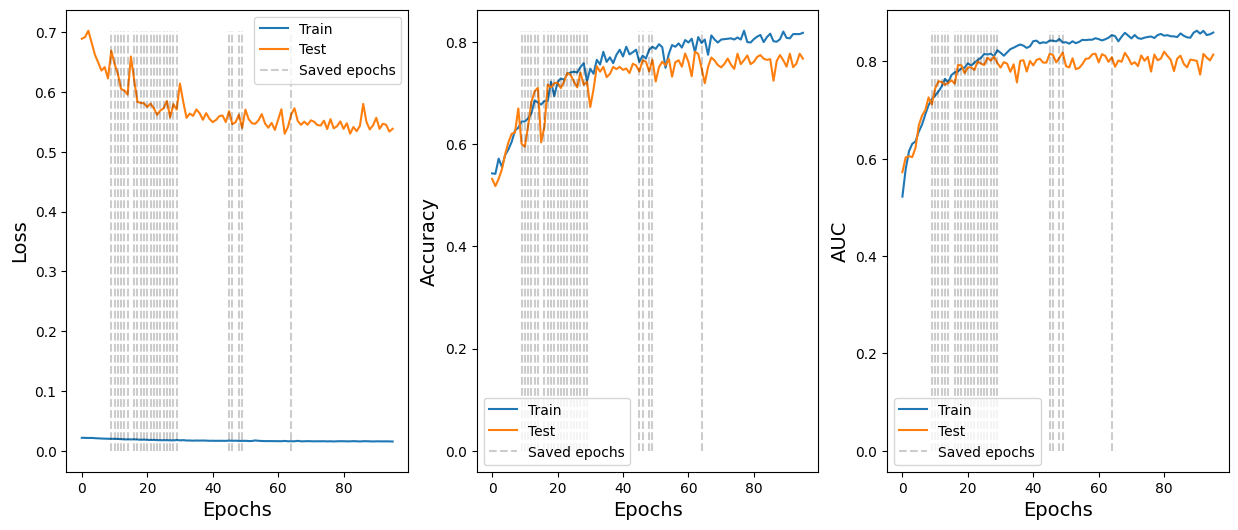

In [59]:
with open('/content/drive/MyDrive/bace_graph_project/models/gcn_models/0_128_250_global_mean_pool_results.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

loss_acc_auc_plots(loaded_dict)

In [ ]:
for key in loaded_dict:
   print(key)

print(loaded_dict["saved_epochs"])

epoch
train_loss
train_acc
train_auc
test_loss
test_acc
test_auc
saved_epochs
test_loss_mov_avg
test_auc_mov_avg
[9, 14, 22, 28, 35, 42, 57, 136]


In [ ]:
# GAT Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 128
num_out_channels = 2
heads=4
# with no edge attributes, global mean pooling best is 70 epochs
nb_epochs = 300
use_edge_attr = True
pool_method = global_mean_pool

# Instantiating GAT Classifier
gat_model = GATClassifier(num_features, num_hidden_channels, num_out_channels, heads, pool_method, use_edge_attr)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(gat_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

"""
gat_results = train(gat_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)
"""

bace_gat_models_path = bace_models_path / "gat_models"


if bace_gat_models_path.is_dir():
  print(f"{bace_gat_models_path} is already a directory")
else:
  print(f"{bace_gat_models_path} is not a directory, creating one")
  bace_gat_models_path.mkdir(parents=True, exist_ok=True)

<IPython.core.display.Javascript object>

drive/MyDrive/bace_graph_project/models/gat_models is already a directory


In [ ]:
nb_repeats = 5
window_size = 10
patience = 30
run_model_repeats(gat_model, adam_optimizer, criterion, bace_gat_models_path, num_hidden_channels, pool_method, nb_epochs, nb_repeats, window_size, patience)


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0216, Train acc: 0.5231, Train AUC: 0.5665, Test loss: 0.6836, Test acc: 0.5681, Test auc: 0.5487
Epoch took 1.24 seconds
Epoch: 1, Train loss: 0.0213, Train acc: 0.5678, Train AUC: 0.6211, Test loss: 0.6639, Test acc: 0.6037, Test auc: 0.6387
Epoch took 1.13 seconds
Epoch: 2, Train loss: 0.0205, Train acc: 0.6182, Train AUC: 0.6693, Test loss: 0.6844, Test acc: 0.5721, Test auc: 0.6336
Epoch took 1.19 seconds
Epoch: 3, Train loss: 0.0205, Train acc: 0.6149, Train AUC: 0.6797, Test loss: 0.6622, Test acc: 0.6010, Test auc: 0.6461
Epoch took 1.13 seconds
Epoch: 4, Train loss: 0.0201, Train acc: 0.6446, Train AUC: 0.7084, Test loss: 0.6861, Test acc: 0.5677, Test auc: 0.6437
Epoch took 1.13 seconds
Epoch: 5, Train loss: 0.0203, Train acc: 0.6248, Train AUC: 0.7227, Test loss: 0.6674, Test acc: 0.6088, Test auc: 0.6382
Epoch took 1.11 seconds
Epoch: 6, Train loss: 0.0196, Train acc: 0.6479, Train AUC: 0.7286, Test loss: 0.6490, Test acc: 0.6358, Test auc: 0.6693
Ep

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0138, Train acc: 0.8727, Train AUC: 0.8932, Test loss: 0.5709, Test acc: 0.7390, Test auc: 0.7805
Epoch took 1.13 seconds
Epoch: 1, Train loss: 0.0138, Train acc: 0.8736, Train AUC: 0.8989, Test loss: 0.5850, Test acc: 0.7198, Test auc: 0.7734
Epoch took 1.17 seconds
Epoch: 2, Train loss: 0.0136, Train acc: 0.8802, Train AUC: 0.8904, Test loss: 0.5717, Test acc: 0.7417, Test auc: 0.7792
Epoch took 1.17 seconds
Epoch: 3, Train loss: 0.0136, Train acc: 0.8826, Train AUC: 0.8932, Test loss: 0.5729, Test acc: 0.7283, Test auc: 0.7667
Epoch took 1.10 seconds
Epoch: 4, Train loss: 0.0136, Train acc: 0.8785, Train AUC: 0.8950, Test loss: 0.5715, Test acc: 0.7350, Test auc: 0.7536
Epoch took 1.10 seconds
Epoch: 5, Train loss: 0.0135, Train acc: 0.8868, Train AUC: 0.8912, Test loss: 0.5642, Test acc: 0.7444, Test auc: 0.7720
Epoch took 1.15 seconds
Epoch: 6, Train loss: 0.0136, Train acc: 0.8793, Train AUC: 0.8950, Test loss: 0.5771, Test acc: 0.7350, Test auc: 0.7541
Ep

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0135, Train acc: 0.8826, Train AUC: 0.8868, Test loss: 0.5676, Test acc: 0.7460, Test auc: 0.7731
Epoch took 1.13 seconds
Epoch: 1, Train loss: 0.0135, Train acc: 0.8868, Train AUC: 0.8970, Test loss: 0.5687, Test acc: 0.7510, Test auc: 0.7557
Epoch took 1.14 seconds
Epoch: 2, Train loss: 0.0136, Train acc: 0.8777, Train AUC: 0.8924, Test loss: 0.5679, Test acc: 0.7456, Test auc: 0.7621
Epoch took 1.16 seconds
Epoch: 3, Train loss: 0.0137, Train acc: 0.8760, Train AUC: 0.8899, Test loss: 0.5815, Test acc: 0.7287, Test auc: 0.7476
Epoch took 1.23 seconds
Epoch: 4, Train loss: 0.0133, Train acc: 0.8934, Train AUC: 0.8869, Test loss: 0.5767, Test acc: 0.7358, Test auc: 0.7654
Epoch took 1.13 seconds
Epoch: 5, Train loss: 0.0135, Train acc: 0.8843, Train AUC: 0.8900, Test loss: 0.5757, Test acc: 0.7327, Test auc: 0.7679
Epoch took 1.14 seconds
Epoch: 6, Train loss: 0.0134, Train acc: 0.8901, Train AUC: 0.8888, Test loss: 0.5710, Test acc: 0.7417, Test auc: 0.7800
Ep

KeyboardInterrupt: 

In [ ]:
print(type(adam_optimizer))


In [ ]:
loss_and_acc_plots(gat_results)

In [ ]:
# GraphConv Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 64
num_out_channels = 2
# global mean pooling, best is 50 epochs
nb_epochs = 50
pool_method = global_mean_pool

# Instantiating GAT Classifier
graphconv_model = GraphConvClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(graphconv_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(graphconv_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

"""
graphconv_results = train(graphconv_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)
"""

In [ ]:
# loss_and_acc_plots(graphconv_results)

In [ ]:
# GINConv Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 64
num_out_channels = 2
num_layers = 3
nb_epochs = 50
pool_method = global_mean_pool

# Instantiating GINConv Classifier
ginconv_model = GINConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(ginconv_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(ginconv_model.parameters())
criterion = torch.nn.CrossEntropyLoss()


ginconv_results = train(ginconv_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)



In [ ]:
# loss_and_acc_plots(ginconv_results)

In [ ]:
# GINEConv Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 64
num_out_channels = 2
num_layers = 3
# best number of epochs with edge attributes is about 15
nb_epochs = 15
pool_method = global_mean_pool
use_edge_attr = True
edge_dim = dataset[0].edge_attr.shape[1]

# Instantiating GINEConv Classifier
gineconv_model = GINEConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method, use_edge_attr, edge_dim)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(gineconv_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(gineconv_model.parameters())
criterion = torch.nn.CrossEntropyLoss()


gineconv_results = train(gineconv_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)


In [ ]:
loss_and_acc_plots(gineconv_results)

In [ ]:

gat_train_auroc, gat_test_auroc, gat_train_report_df, gat_test_report_df = metric_func(gat_model, train_dataset, test_dataset)
"""
graphconv_train_auroc, graphconv_test_auroc, graphconv_train_report_df, graphconv_test_report_df = metric_func(graphconv_model, train_dataset, test_dataset)

ginconv_train_auroc, ginconv_test_auroc, ginconv_train_report_df, ginconv_test_report_df = metric_func(ginconv_model, train_dataset, test_dataset)
"""
gineconv_train_auroc, gineconv_test_auroc, gineconv_train_report_df, gineconv_test_report_df = metric_func(gineconv_model, train_dataset, test_dataset)



In [ ]:
"""
print("GCN results:")
display("train AUC:", train_auroc, "test AUC:", test_auroc, train_report_df, test_report_df)
"""
print("GAT results:")
display("train AUC:", gat_train_auroc, "test AUC:", gat_test_auroc, gat_train_report_df, gat_test_report_df)
"""
print("GraphConv results:")
display("train AUC:", graphconv_train_auroc, "test AUC:", graphconv_test_auroc, graphconv_train_report_df, graphconv_test_report_df)

print("GinConv results:")
display("train AUC:", ginconv_train_auroc, "test AUC:", ginconv_test_auroc, ginconv_train_report_df, ginconv_test_report_df)
"""
print("GineConv results:")
display("train AUC:", gineconv_train_auroc, "test AUC:", gineconv_test_auroc, gineconv_train_report_df, gineconv_test_report_df)